<a href="https://colab.research.google.com/github/enakai00/rl_book_solutions/blob/master/Chapter04/Exercise_4_7_(Policy_Iteration)_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import poisson

from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

In [0]:
class CarRental:
  def __init__(self, size=20, gamma=0.9,
               fst_rent_mean=3, snd_rent_mean=4,
               fst_ret_mean=3, snd_ret_mean=2):
    self.size = size
    self.fst_rent_mean = fst_rent_mean
    self.snd_rent_mean = snd_rent_mean    
    self.fst_ret_mean = fst_ret_mean
    self.snd_ret_mean = snd_ret_mean       
    self.gamma = gamma

    self.states = [(fst, snd) for fst in range(size+1) for snd in range(size+1)]
    self.value = {}
    self.policy = {} # Greedy policy
    
    # Initialize with 0 values
    for s in self.states:
      self.value[s] = 0
      
    # Initialize with policy of moving no cars
    for s in self.states:
      self.policy[s] = 0
      
  def show_value(self):
    value = np.zeros((self.size+1, self.size+1))
    for s in self.states:
      (fst, snd) = s
      value[fst][snd] = self.value[s]
      
    x = range(0, self.size+1)
    y = range(0, self.size+1)
    X, Y = np.meshgrid(x, y)
    Z = value[X, Y]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(X, Y, Z, color='gray')
    ax.set_xticks(range(0, self.size+1, 4))
    ax.set_yticks(range(0, self.size+1, 4))
    ax.set_xlabel('second')
    ax.set_ylabel('first')
    ax.set_zlabel('value')

  def show_policy(self):
    result = np.zeros((self.size+1, self.size+1))
    for s in self.states:
      (fst, snd) = s
      result[fst][snd] = self.policy[s]
    sns.heatmap(result, cbar=False, annot=True, cmap='seismic')

In [0]:
def memoize(f):
    cache = {}
    def helper(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    return helper

@memoize
def _poisson_pmf(n, mean):
  return poisson.pmf(n, mean)
  
@memoize
def poisson_pmf(n, n_max, mean):
  if n > n_max:
    return 0
  if n == n_max:
    return 1-sum([poisson.pmf(n, mean) for n in range(n_max)])
  return _poisson_pmf(n, mean)

In [0]:
def action_value_update(car_rental, s, a):
  size = car_rental.size
  fst_rent_mean = car_rental.fst_rent_mean
  snd_rent_mean = car_rental.snd_rent_mean    
  fst_ret_mean = car_rental.fst_ret_mean
  snd_ret_mean = car_rental.snd_ret_mean  
  gamma = car_rental.gamma
  
  (fst, snd) = s
  fst -= a # Moving cars
  snd += a # Moving cars

  r_base = 0
  # Additional parking lot fee.
  if fst > 10:
    r_base = -4
  if snd > 10:
    r_base -= 4
            
  q_new = 0
  # Loop for possible next states
  for fst_rent in range(fst+1):
    # Prob for fst_rent
    prob1 = poisson_pmf(fst_rent, fst, fst_rent_mean)
        
    for snd_rent in range(snd+1):
      # Prob for fst_rent * snd_rent
      prob2 = prob1 * poisson_pmf(snd_rent, snd, snd_rent_mean)
      if a > 0:
        # One car can be moved from fst to snd for free
        r = r_base -2 * abs(a-1) + 10 * (fst_rent + snd_rent)
      else:
        r = r_base -2 * abs(a) + 10 * (fst_rent + snd_rent)

      for fst_ret in range(size-(fst-fst_rent)+1):
        # Prob for fst_rent * snd_rent * fst_ret
        prob3 = prob2 * poisson_pmf(fst_ret, size-(fst-fst_rent), fst_ret_mean)
         
        for snd_ret in range(size-(snd-snd_rent)+1):
          # Prob for fst_rent * snd_rent * fst_ret * snd_ret
          prob = prob3 * poisson_pmf(snd_ret, size-(snd-snd_rent), snd_ret_mean)

          s_new = (fst - fst_rent + fst_ret,
                   snd - snd_rent + snd_ret)
          q_new += prob * (r + gamma*car_rental.value[s_new])

  return q_new

In [0]:
def policy_eval(car_rental, theta=1.0):
  c = 0
  while True:
    deltas = []
    for s in car_rental.states:
      a = car_rental.policy[s]
      v = car_rental.value[s]
      v_new = action_value_update(car_rental, s, a)
      car_rental.value[s] = v_new
      deltas.append(abs(v-v_new))

    c += 1
    print ('End of iteration {}, delta={}'.format(c, max(deltas)))
    if max(deltas) < theta:
      break

In [0]:
def policy_update(car_rental):
  for s in car_rental.states:      
    # Search for argmax
    q = {}
    (_fst, _snd)  = s
    for a in range(-min(_snd, 5), min(_fst, 5)+1):
      q[a] = action_value_update(car_rental, s, a)

    car_rental.policy[s] = max(q, key=q.get)

In [0]:
car_rental = CarRental(size=20)

## 1st iteration

End of iteration 1, delta=172.6082577767952
End of iteration 2, delta=120.86733148490288
End of iteration 3, delta=82.7786042752544
End of iteration 4, delta=65.22547685589669
End of iteration 5, delta=52.09847374028459
End of iteration 6, delta=40.67176264259314
End of iteration 7, delta=31.886204556592304
End of iteration 8, delta=25.374602660822802
End of iteration 9, delta=21.20574019168879
End of iteration 10, delta=17.771298390603306
End of iteration 11, delta=14.861553487198876
End of iteration 12, delta=12.403819655872155
End of iteration 13, delta=10.333289606925632
End of iteration 14, delta=8.593402492768917
End of iteration 15, delta=7.135038068973813
End of iteration 16, delta=5.915602723504946
End of iteration 17, delta=4.898251315060406
End of iteration 18, delta=4.051234936913886
End of iteration 19, delta=3.3473266217064293
End of iteration 20, delta=2.763294616850146
End of iteration 21, delta=2.2794121767853994
End of iteration 22, delta=1.8790031687647684
End of ite

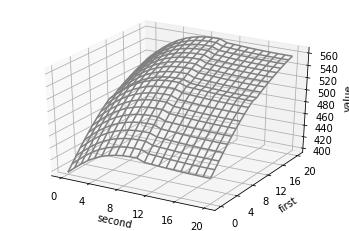

In [8]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 1min 42s, sys: 161 ms, total: 1min 42s
Wall time: 1min 42s


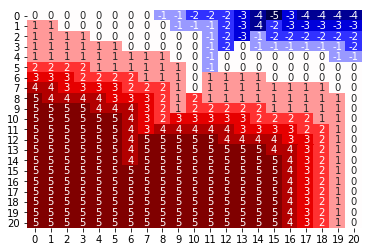

In [9]:
%%time
policy_update(car_rental)
car_rental.show_policy()

## 2nd iteration

End of iteration 1, delta=89.55210212124598
End of iteration 2, delta=9.340510556211825
End of iteration 3, delta=5.040161541391967
End of iteration 4, delta=3.7525935382278703
End of iteration 5, delta=3.168974705027324
End of iteration 6, delta=2.6239571754770736
End of iteration 7, delta=2.156331197123336
End of iteration 8, delta=1.7678363880202141
End of iteration 9, delta=1.4478087290465282
End of iteration 10, delta=1.1850448503810185
End of iteration 11, delta=0.9696595730978856
CPU times: user 2min 33s, sys: 29.9 ms, total: 2min 33s
Wall time: 2min 34s


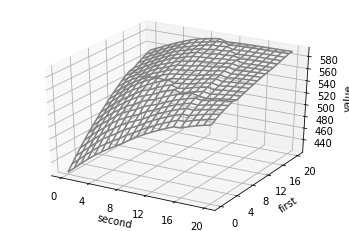

In [10]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 15s, sys: 153 ms, total: 2min 16s
Wall time: 2min 16s


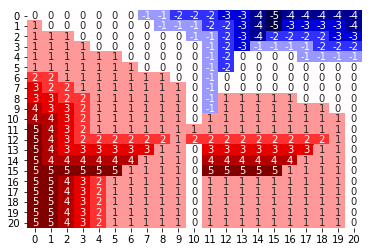

In [11]:
%%time
policy_update(car_rental)
car_rental.show_policy()

## 3rd iteration

End of iteration 1, delta=12.181042977642619
End of iteration 2, delta=6.279261621546425
End of iteration 3, delta=3.225080898682563
End of iteration 4, delta=1.812103641247404
End of iteration 5, delta=1.2388145436937066
End of iteration 6, delta=0.9394699226913872
CPU times: user 1min 26s, sys: 22 ms, total: 1min 26s
Wall time: 1min 26s


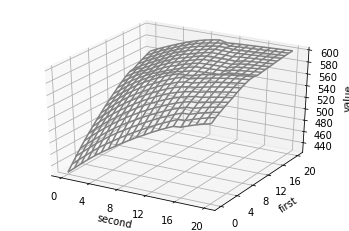

In [12]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 12s, sys: 150 ms, total: 2min 12s
Wall time: 2min 13s


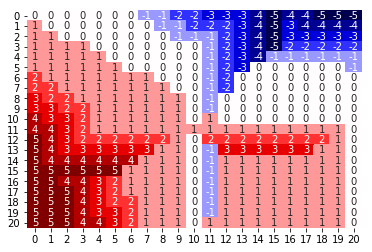

In [13]:
%%time
policy_update(car_rental)
car_rental.show_policy()

## 4th iteration

End of iteration 1, delta=3.7690996742405787
End of iteration 2, delta=0.7821909596415253
CPU times: user 28.9 s, sys: 23 ms, total: 29 s
Wall time: 29 s


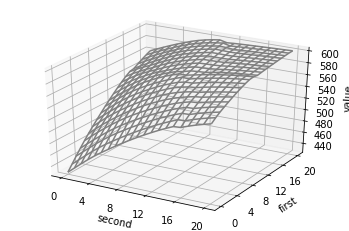

In [14]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 13s, sys: 166 ms, total: 2min 13s
Wall time: 2min 13s


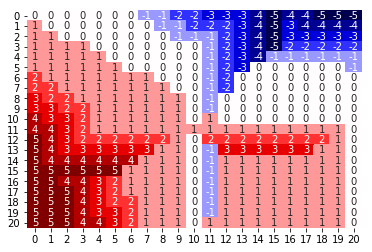

In [15]:
%%time
policy_update(car_rental)
car_rental.show_policy()

## 5th iteration

End of iteration 1, delta=0.5210126217469906
CPU times: user 14.8 s, sys: 15 ms, total: 14.8 s
Wall time: 14.8 s


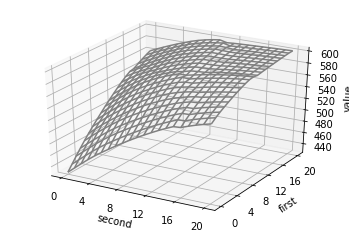

In [16]:
%%time
policy_eval(car_rental)
car_rental.show_value()

CPU times: user 2min 13s, sys: 144 ms, total: 2min 13s
Wall time: 2min 13s


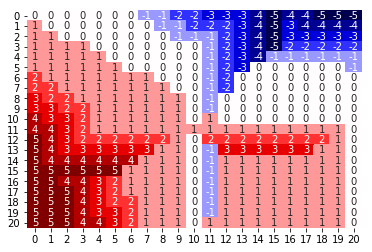

In [17]:
%%time
policy_update(car_rental)
car_rental.show_policy()